In [1]:
import scanpy as sc
import pandas as pd
import sctk as sk
import numpy as np
import seaborn as sns

# Load tables of differential accessibility
From bulk ATAC-seq analysis

In [2]:
# Load differential accessibility data into tables
diff_peaks = dict()
diff_peaks['Belinostat | cytokine'] = pd.read_csv("tables/differential_peak_table_FDR05_annotated_matched_Belinostat | cytokine.csv")
diff_peaks['Cytokine + Belinostat'] = pd.read_csv("tables/differential_peak_table_FDR05_annotated_matched_Cytokine + Belinostat.csv")
diff_peaks['Cytokine'] = pd.read_csv("tables/differential_peak_table_FDR05_annotated_matched_Cytokine.csv")

In [3]:
# Abs fold change filter

In [4]:
# Filter for up-regulated peaks only
diff_peaks_up = dict()
diff_peaks_down = dict()
for key in diff_peaks:
    diff_peaks_up[key] = diff_peaks[key][diff_peaks[key].direction == 'up']
    diff_peaks_down[key] = diff_peaks[key][diff_peaks[key].direction == 'down']
    
#diff_peaks

In [5]:
# Get top peaks in dictionary
top_n = 5000
top_peaks = {name: tab.atac_peak.dropna()[0:top_n] for name, tab in diff_peaks.items()}

# Split top peaks into up and down-regulated
top_peaks_down = {name: tab.atac_peak.dropna()[0:top_n] for name, tab in diff_peaks_down.items()}
top_peaks_up = {name: tab.atac_peak.dropna()[0:top_n] for name, tab in diff_peaks_up.items()}
#top_peaks

In [6]:
# Count numbers of mapped peaks

In [7]:
[len(x) for x in top_peaks_down.values()]

[1546, 5000, 5000]

In [8]:
[len(x) for x in top_peaks_up.values()]

[34, 328, 410]

In [26]:
top_peaks_up.keys()

dict_keys(['Belinostat | cytokine', 'Cytokine + Belinostat', 'Cytokine'])

# Load scATAC-seq data

In [9]:
# Load anndata object
atac = sc.read('../fibroblast_reanalysis/data/scATAC_PeakMatrix_fibro.processed.h5ad')

In [10]:
atac

AnnData object with n_obs × n_vars = 56689 × 407383
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'Clusters1', 'ReadsInPeaks', 'FRIP', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 

In [11]:
# Print some names
atac.var_names[0:10]

Index(['chr1:794840-795340,FAM87B,Distal', 'chr1:807550-808050,FAM87B,Distal',
       'chr1:811011-811511,FAM87B,Distal',
       'chr1:817090-817590,FAM87B,Promoter',
       'chr1:817824-818324,FAM87B,Exonic', 'chr1:818479-818979,FAM87B,Exonic',
       'chr1:820945-821445,FAM87B,Distal',
       'chr1:826556-827056,LINC00115,Exonic',
       'chr1:827241-827741,LINC00115,Promoter',
       'chr1:830679-831179,LINC00115,Intronic'],
      dtype='object', name='index')

# Score cells by differentially accessible peaks

In [20]:
# Downregulated
peaks = top_peaks_down['Belinostat | cytokine']
sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='Belinostat | cytokine_down_score')

peaks = top_peaks_down['Cytokine + Belinostat']
sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='Cytokine + Belinostat_down_score')

peaks = top_peaks_down['Cytokine']
sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='cytokine_down_score')

In [21]:
# Upregulated
peaks = top_peaks_up['Belinostat | cytokine']
sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='Belinostat | cytokine_up_score')

peaks = top_peaks_up['Cytokine + Belinostat']
sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='Cytokine + Belinostat_up_score')

peaks = top_peaks_up['Cytokine']
sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='cytokine_up_score')

In [22]:
#score_names = ['belinostat_score', 'cytokine_score', 'belinostat_cytokine_score']
score_names = ['Belinostat | cytokine_down_score', 'Cytokine + Belinostat_down_score', 'cytokine_down_score',
               'Belinostat | cytokine_up_score', 'Cytokine + Belinostat_up_score', 'cytokine_up_score']

In [24]:
# sns.set_style("ticks")  # to prevent gridlines
# sc.pl.violin(
#     atac,
#     groupby='annot1',
#     keys=score_names,
#     #jitter=False,
#     stripplot=False,
#     inner='box',
#     #figsize=(20, 4),
#     rotation=90,
#     #save="_ATAC_bulkDE_signature_projection.pdf",
#     grid=False
# )

In [28]:
# Standardize scores
for name in score_names:
    x = atac.obs[name].values
    atac.obs[name] = (x-x.mean()) / np.std(x)

In [29]:
atac

AnnData object with n_obs × n_vars = 56689 × 407383
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'Clusters1', 'ReadsInPeaks', 'FRIP', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 

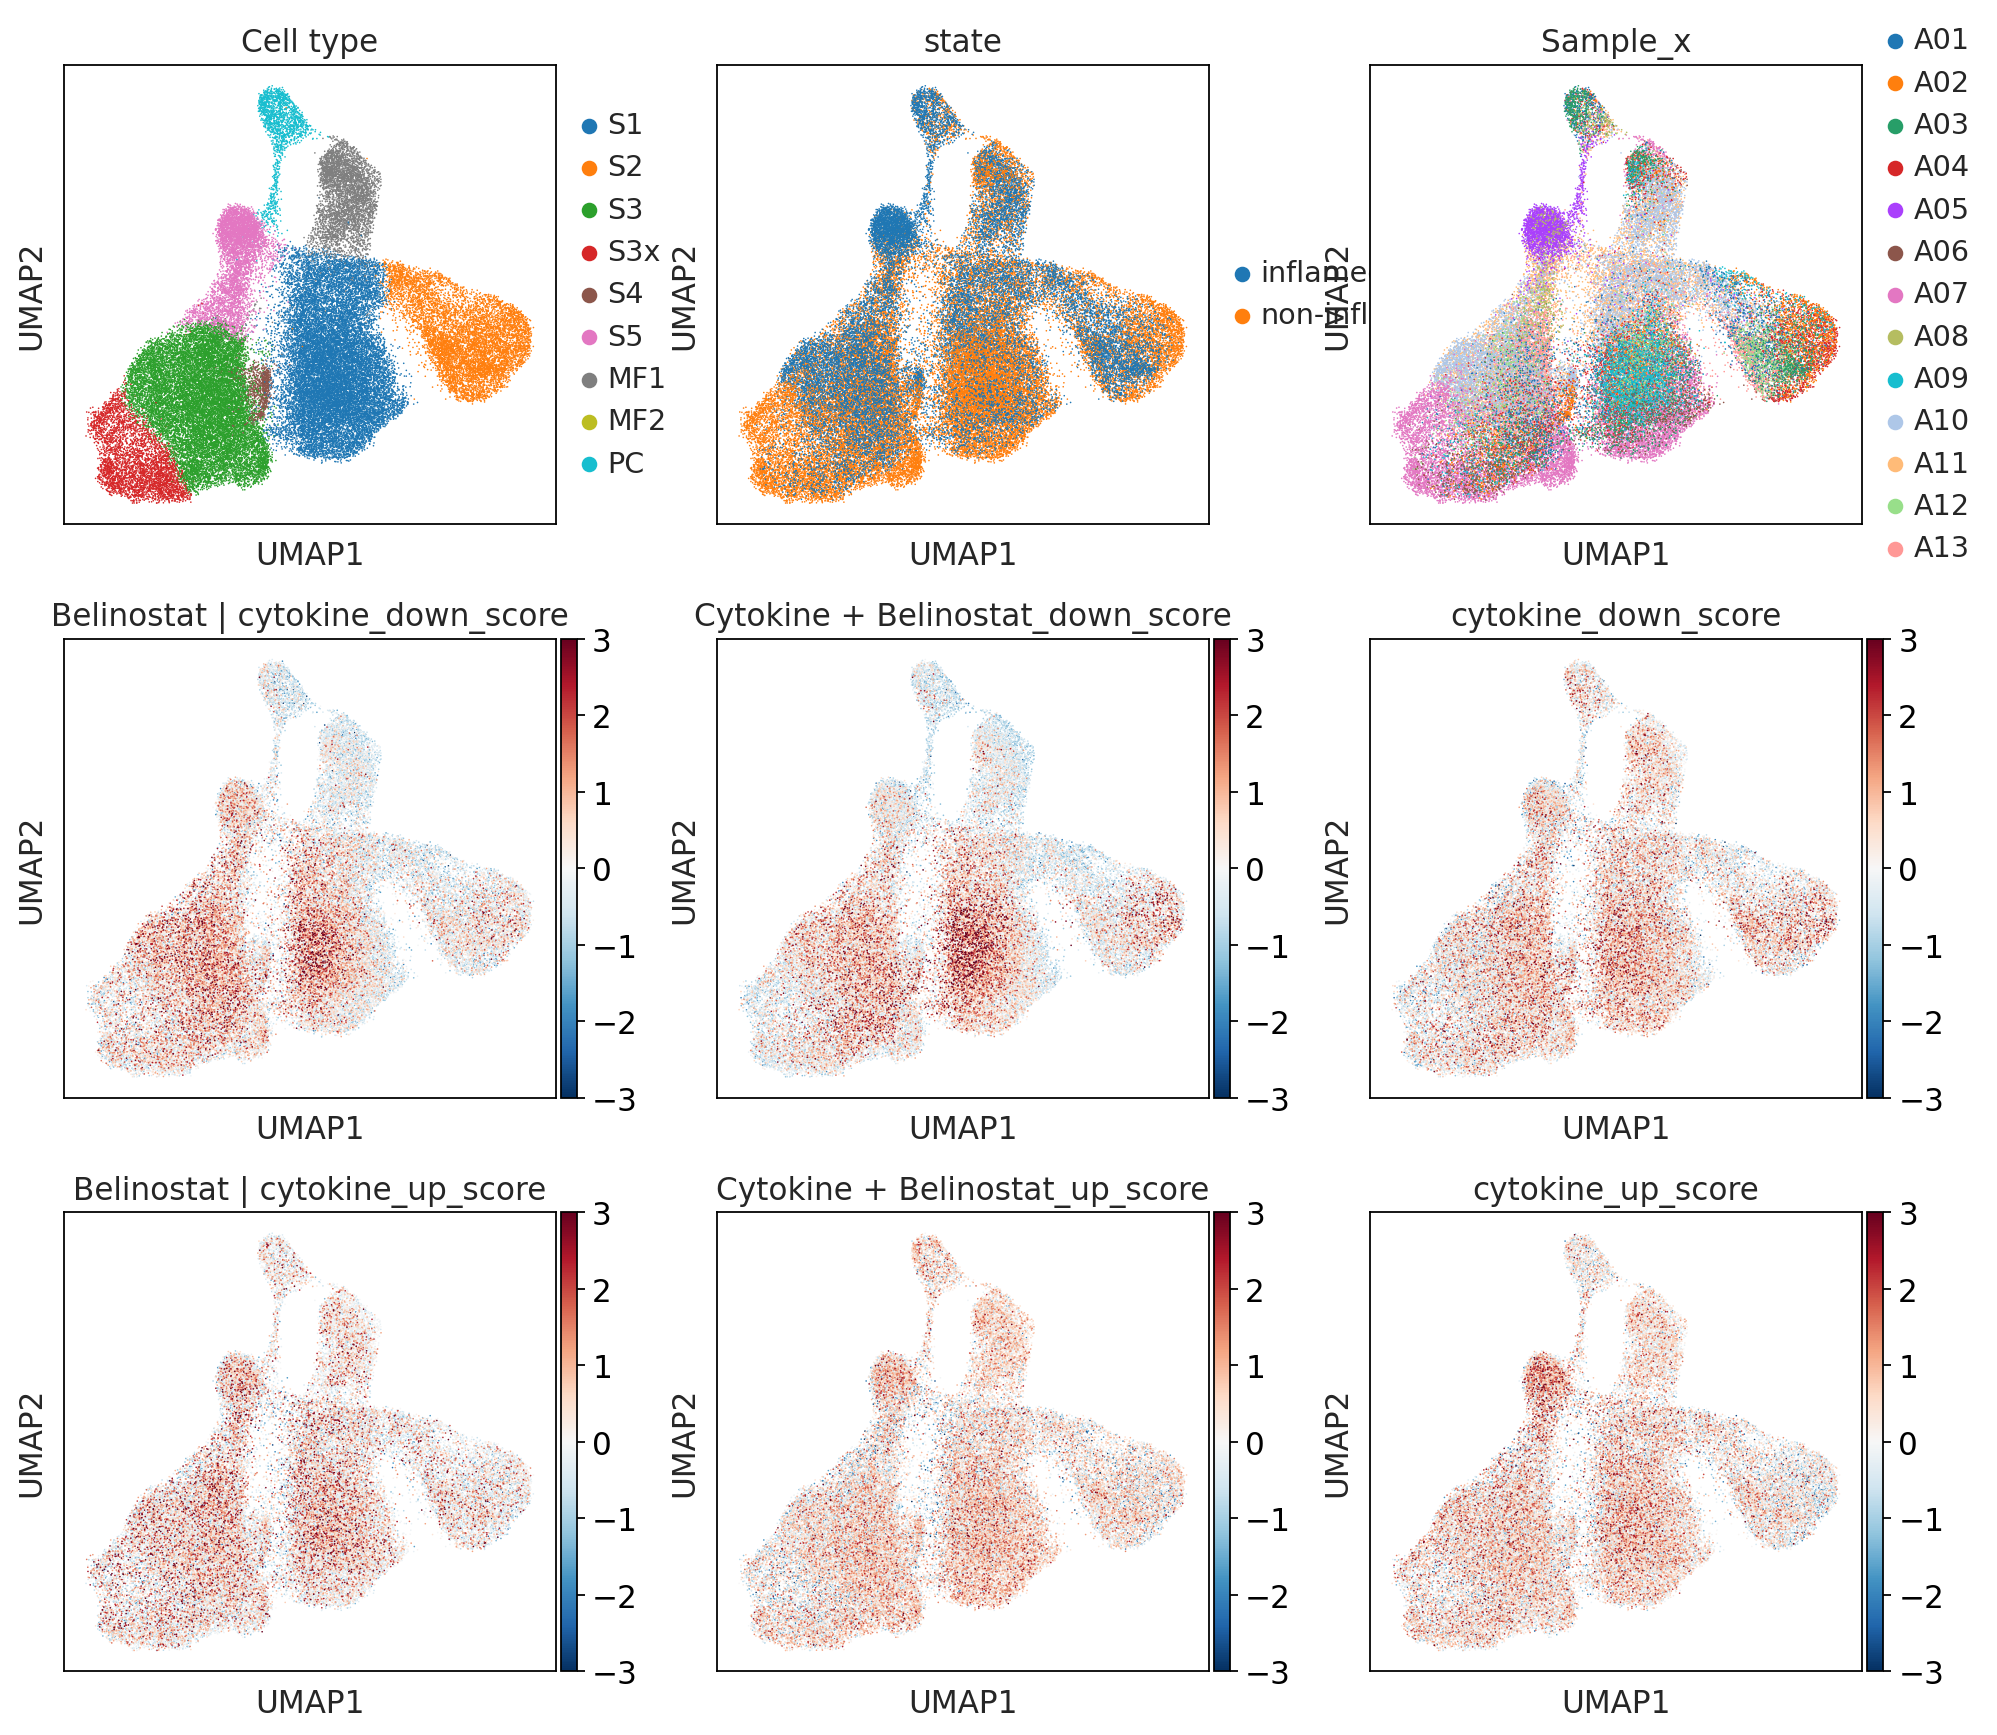

In [30]:
# Plot standardized scores on scATAC-seq UMAP
sk.set_figsize((3, 3))
sc.set_figure_params(dpi_save=300)

sc.pl.embedding(atac,
                basis='umap',
                color=['annot1', 'state', 'Sample_x'] + score_names,
                title=['Cell type'],
                ncols=3,
                vmin=-3, vmax=3,
                cmap='RdBu_r',
                save="_ATAC_bulkDE_mixture_signature_projection_scaled.pdf"
)

In [40]:
from matplotlib import pyplot as plt

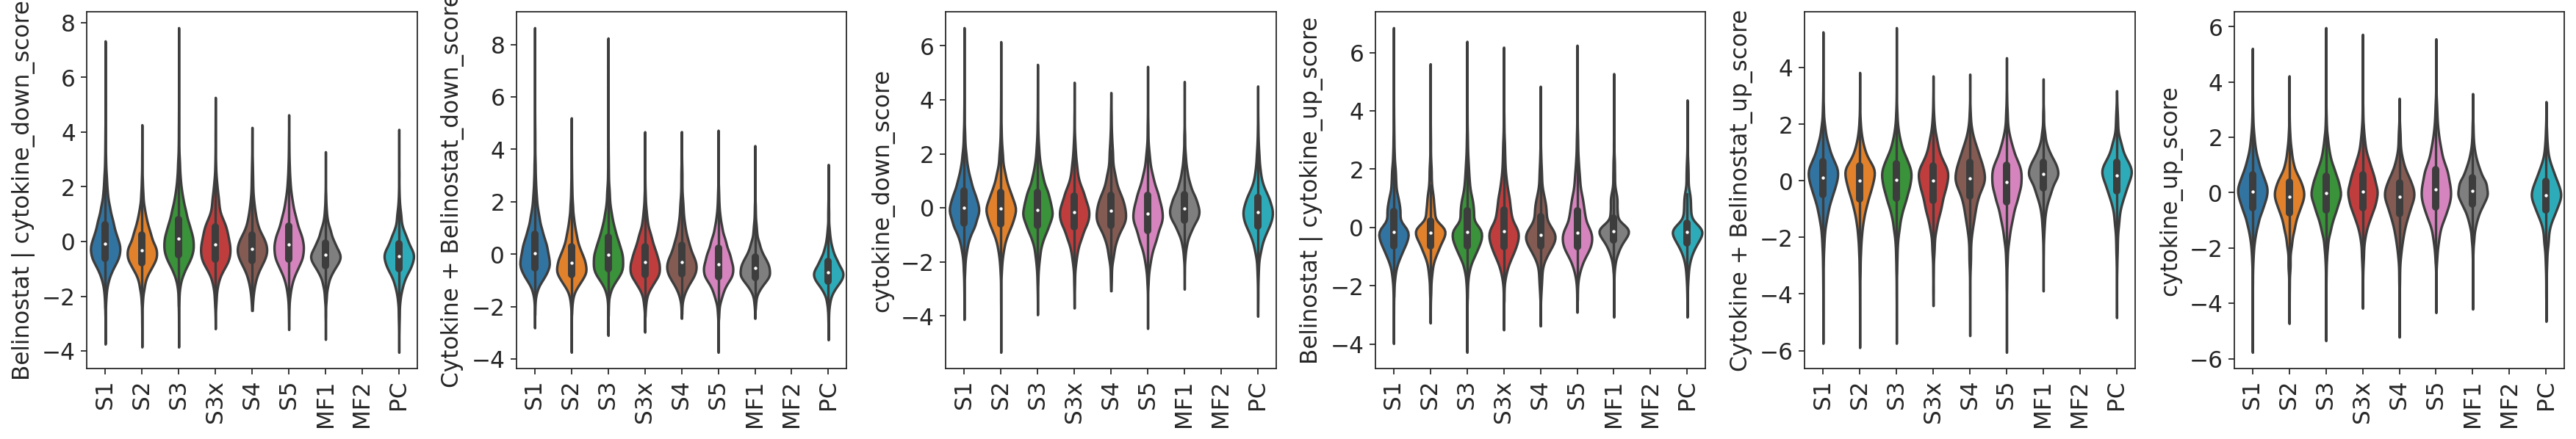

In [42]:
sns.set_style("ticks")  # to prevent gridlines


#fig, ax = plt.subplots()

sc.pl.violin(
    atac,
    groupby='annot1',
    keys=score_names,
    #jitter=False,
    stripplot=False,
    inner='box',
    #figsize=(20, 4),
    rotation=90,
    save="_ATAC_bulkDE_mixture_signature_projection_scaled",
    grid=False
)

#ax.set_ylim(bottom=-3,top=3)

#plt.show()

In [32]:
#atac

# Score cells by top PCA loadings, global sample-based analysis

In [103]:
pd.set_option('display.max_columns', 100)

In [104]:
# Load peak set for all, incuding PCA loadings values and matched ATAC peaks
peaks_all = pd.read_csv("tables/peak_table_all_PCA_loadings_matched.csv")

In [105]:
peaks_all.atac_peak.isna().sum()  # unmatched peaks

186741

In [106]:
peaks_all

seqnames     start       end  width strand  \
0          chr1     41457     41706    250      *   
1          chr1     41844     42454    611      *   
2          chr1     46484     46643    160      *   
3          chr1     47458     47787    330      *   
4          chr1     56157     56477    321      *   
...         ...       ...       ...    ...    ...   
334845     chrY  24270821  24270977    157      *   
334846     chrY  24271380  24271691    312      *   
334847     chrY  24368003  24368602    600      *   
334848     chrY  25301540  25302124    585      *   
334849     chrY  25398454  25398765    312      *   

                                        annotation  geneChr  geneStart  \
0                                Distal Intergenic        1      34611   
1                                Distal Intergenic        1      34611   
2                                Distal Intergenic        1      34611   
3                                Distal Intergenic        1      34611   
4                                Distal Intergenic        1      69091   
...                                            ...      ...        ...   
334845  Intron (uc010nxc.1/378950, intron 6 of 11)       24   24291113   
334846  Intron (uc010nxc.1/378950, intron 6 of 11)       24   24291113   
334847                           Distal Intergenic       24   24314689   
334848   Intron (uc004fvl.3/1617, intron 21 of 27)       24   25275502   
334849  Intron (uc022cok.1/57055, intron 13 of 21)       24   25372491   

         geneEnd  geneLength  geneStrand  geneId transcriptId  distanceToTSS  \
0          36081        1471           2  641702   uc001aak.3          -5376   
1          36081        1471           2  641702   uc001aak.3          -5763   
2          36081        1471           2  641702   uc001aak.3         -10403   
3          36081        1471           2  641702   uc001aak.3         -11377   
4          70008         918           1   79501   uc001aal.1         -12614   
...          ...         ...         ...     ...          ...            ...   
334845  24292981        1869           1   84672   uc010nxf.2         -20136   
334846  24292981        1869           1   84672   uc010nxf.2         -19422   
334847  24329089       14401           2  378951   uc010nxh.3         -38914   
334848  25345254       69753           2    1617   uc004fvl.3          43130   
334849  25431683       59193           1   57055   uc010nxl.1          25963   

                ENSEMBL   SYMBOL  \
0       ENSG00000282591  FAM138F   
1       ENSG00000282591  FAM138F   
2       ENSG00000282591  FAM138F   
3       ENSG00000282591  FAM138F   
4       ENSG00000186092    OR4F5   
...                 ...      ...   
334845  ENSG00000131538    TTTY6   
334846  ENSG00000131538    TTTY6   
334847  ENSG00000226941   RBMY1J   
334848  ENSG00000188120     DAZ1   
334849  ENSG00000205944     DAZ2   

                                                 GENENAME   annotation_short  \
0            family with sequence similarity 138 member F  Distal Intergenic   
1            family with sequence similarity 138 member F  Distal Intergenic   
2            family with sequence similarity 138 member F  Distal Intergenic   
3            family with sequence similarity 138 member F  Distal Intergenic   
4        olfactory receptor family 4 subfamily F member 5  Distal Intergenic   
...                                                   ...                ...   
334845             testis-specific transcript, Y-linked 6             Intron   
334846             testis-specific transcript, Y-linked 6             Intron   
334847  RNA binding motif protein Y-linked family 1 me...  Distal Intergenic   
334848                           deleted in azoospermia 1             Intron   
334849                           deleted in azoospermia 2             Intron   

             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       0.001338 -0.000218  0.000058  0.001293

In [107]:
peaks_all.columns

Index(['seqnames', 'start', 'end', 'width', 'strand', 'annotation', 'geneChr',
       'geneStart', 'geneEnd', 'geneLength', 'geneStrand', 'geneId',
       'transcriptId', 'distanceToTSS', 'ENSEMBL', 'SYMBOL', 'GENENAME',
       'annotation_short', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
       'PC8', 'PC9', 'PC10', 'atac_peak'],
      dtype='object')

In [108]:
peaks_all.iloc[np.argsort(-peaks_all.PC1), :]

seqnames     start       end  width strand  \
312307    chr21   8244682   8246772   2091      *   
241968    chr15  20356549  20359099   2551      *   
285473    chr18  47029205  47031169   1965      *   
285460    chr18  46965331  46966570   1240      *   
312320    chr21   8427711   8429803   2093      *   
...         ...       ...       ...    ...    ...   
304731    chr20  23349770  23350934   1165      *   
98493      chr5  90409230  90410312   1083      *   
199574    chr11  68460125  68461232   1108      *   
38584      chr2  63588019  63589286   1268      *   
214799    chr12  62602355  62603914   1560      *   

                                        annotation  geneChr  geneStart  \
312307                           Distal Intergenic       21    9825832   
241968                           Distal Intergenic       15   20487997   
285473                           Distal Intergenic       18   47014851   
285460   Intron (uc002ldi.1/54808, intron 1 of 16)       18   46570172   
312320                           Distal Intergenic       21    9825832   
...                                            ...      ...        ...   
304731        Exon (uc002wsy.3/64412, exon 5 of 6)       20   23345000   
98493   Intron (uc003kjt.4/84059, intron 87 of 89)        5   90195079   
199574                           Distal Intergenic       11   68451983   
38584     Intron (uc002sce.3/51057, intron 4 of 8)        2   63348535   
214799   Intron (uc001sqx.3/338811, intron 1 of 5)       12   62102029   

         geneEnd  geneLength  geneStrand     geneId transcriptId  \
312307   9826011         180           1  100500862   uc021wgv.1   
241968  20496811        8815           1     646096   uc001ytf.1   
285473  47018935        4085           2       6139   uc021ujz.1   
285460  46987079      416908           2      54808   uc002ldi.1   
312320   9826011         180           1  100500862   uc021wgv.1   
...          ...         ...         ...        ...          ...   
304731  23353683        8684           1      64412   uc002wsz.3   
98493   90460033      264955           1      84059   uc003kjx.3   
199574  68458643        6661           1      51083   uc001oob.3   
38584   63661070      312536           2      51057   uc002sce.3   
214799  62586620      484592           2     338811   uc001sqw.3   

        distanceToTSS          ENSEMBL     SYMBOL  \
312307       -1579060  ENSG00000275708  MIR3648-1   
241968        -128898  ENSG00000259156    CHEK2P2   
285473         -10270  ENSG00000265681      RPL17   
285460          20509  ENSG00000141627        DYM   
312320       -1396029  ENSG00000275708  MIR3648-1   
...               ...              ...        ...   
304731           4770  ENSG00000125812       GZF1   
98493          214151  ENSG00000164199     ADGRV1   
199574           8142  ENSG00000069482        GAL   
38584           71784  ENSG00000143951      WDPCP   
214799         -15735  ENSG00000198673      TAFA2   

                                                 GENENAME   annotation_short  \
312307                                    microRNA 3648-1  Distal Intergenic   
241968                                 CHEK2 pseudogene 2  Distal Intergenic   
285473                              ribosomal protein L17  Distal Intergenic   
285460                                           dymeclin             Intron   
312320                                    microRNA 3648-1  Distal Intergenic   
...                                                   ...                ...   
304731               GDNF inducible zinc finger protein 1               Exon   
98493              adhesion G protein-coupled receptor V1             Intron   
199574                     galanin and GMAP prepropeptide  Distal Intergenic   
38584   WD repeat containing planar cell polarity effe...             Intron   
214799                TAFA chemokine like family member 2             Intron   

             PC1       PC2       PC3       PC4       PC5       PC6

In [109]:
# Sort postive and negative PCA loadings

In [114]:
# # With drops of unatched peaks
# #top_k = 2000

# top_k = 10000

# peaks = peaks_all.atac_peak[np.argsort(-peaks_all.PC1)].dropna()[0:top_k]
# sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='PC1_pos_score')

# peaks = peaks_all.atac_peak[np.argsort(peaks_all.PC1)].dropna()[0:top_k]
# sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='PC1_neg_score')

# peaks = peaks_all.atac_peak[np.argsort(-peaks_all.PC2)].dropna()[0:top_k]
# sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='PC2_pos_score')

# peaks = peaks_all.atac_peak[np.argsort(peaks_all.PC2)].dropna()[0:top_k]
# sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name='PC2_neg_score')

In [131]:
# No drops of unmatched peaks
top_k = 10000

n_pca = 4  # PCA

for i in range(1, n_pca + 1):
    print("PC", i)
    
    peaks = peaks_all.atac_peak[np.argsort(-peaks_all[f'PC{i}'])][0:top_k].dropna()
    print(len(peaks))
    sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name=f'PC{i}_pos_score')

    peaks = peaks_all.atac_peak[np.argsort(peaks_all[f'PC{i}'])][0:top_k].dropna()
    print(len(peaks))
    sc.tl.score_genes(atac, peaks, ctrl_size=len(peaks), score_name=f'PC{i}_neg_score')

1
1032
9849
2
5403
5453
3
5158
3861
4
4283
4254


In [132]:
score_names = ["PC1_pos_score", "PC1_neg_score", "PC2_pos_score", "PC2_neg_score", "PC3_pos_score", "PC3_neg_score", "PC4_pos_score", "PC4_neg_score"]

In [133]:
# Standardize scores
for name in score_names:
    x = atac.obs[name].values
    atac.obs[name] = (x-x.mean()) / np.std(x)

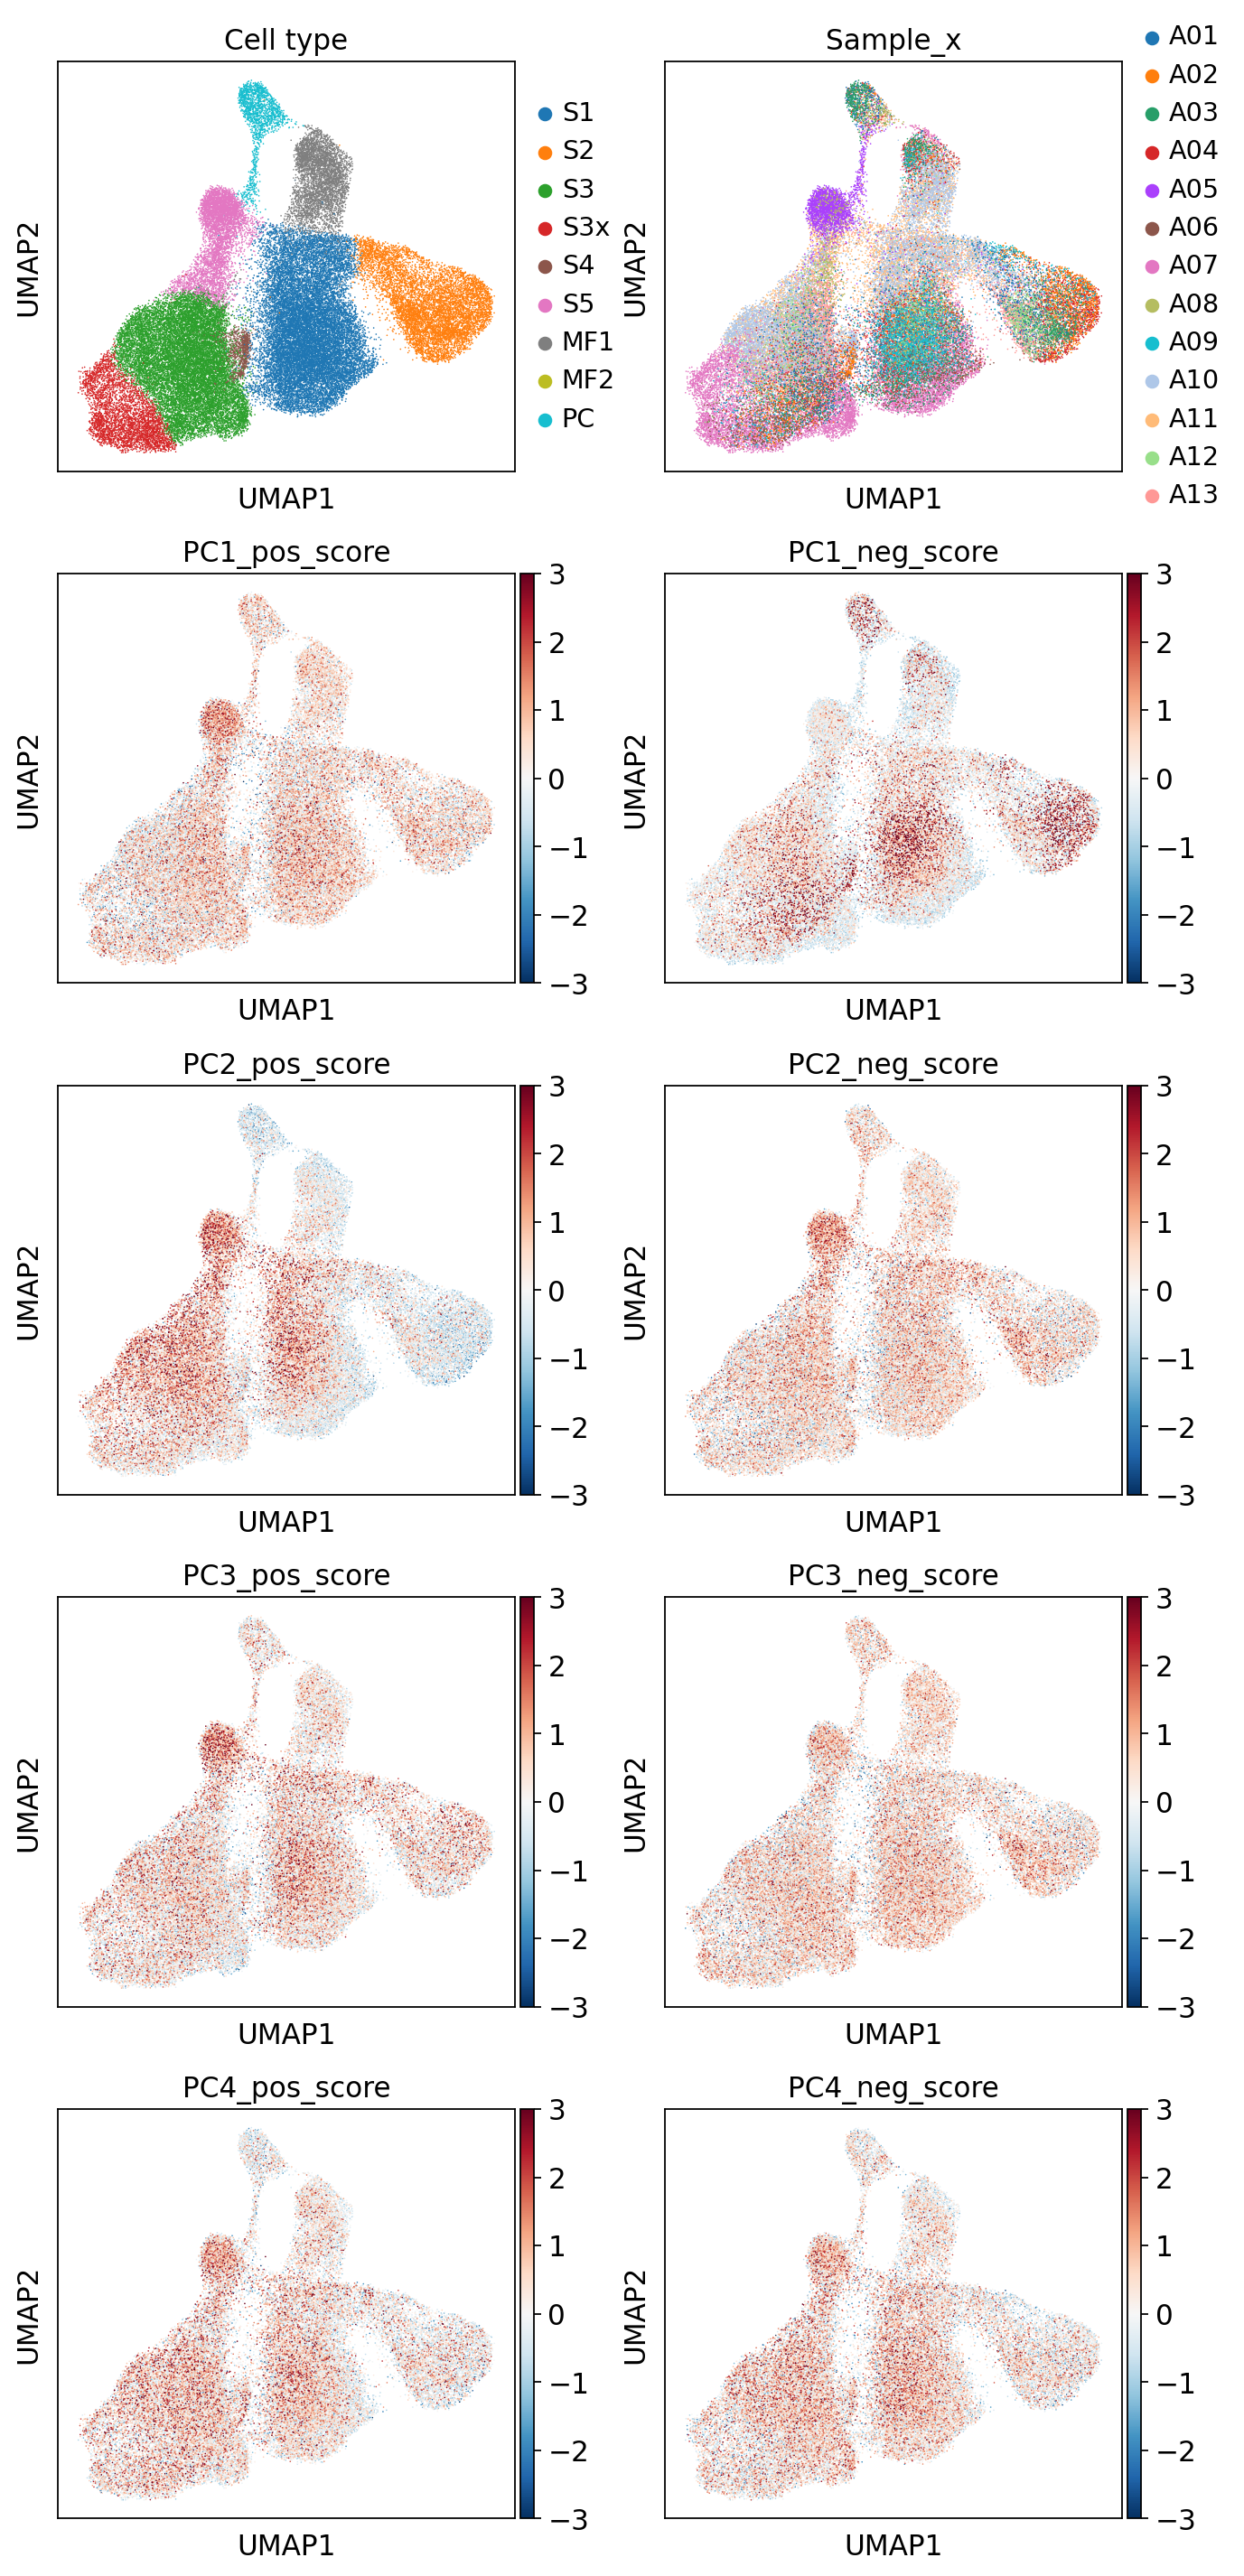

In [134]:
# Plot standardized scores on scATAC-seq UMAP
sk.set_figsize((3, 3))
sc.set_figure_params(dpi_save=300)

sc.pl.embedding(atac,
                basis='umap',
                color=['annot1', 'Sample_x'] + score_names,
                title=['Cell type'],
                ncols=2,
                vmin=-3, vmax=3,
                cmap='RdBu_r',
                #save="_ATAC_bulkDE_mixture_signature_projection_scaled__________.pdf"
)